LLMs such as GPT (generative pretrained transformer), are large deep neural network architectires designed to generate new text one word at a time. In deep learning, the term "parameters" refers to the trainable weights of the model, these weights are essentially the internal variable that can be modified to reduce specific loss functions. These modifications allow the model to learn from the trainable date.

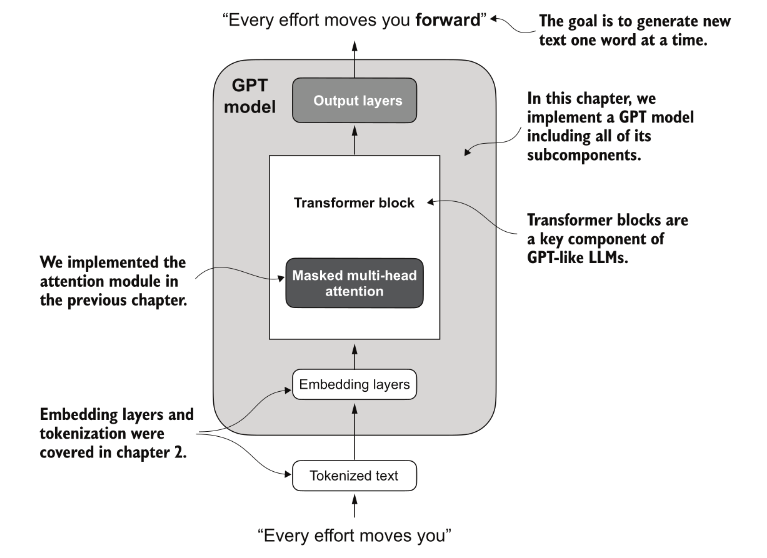

For example, in a neural network layer that is represented by a 2,048 × 2,048–dimensional
matrix (or tensor) of weights, each element of this matrix is a parameter. Since there
are 2,048 rows and 2,048 columns, the total number of parameters in this layer is 2,048
multiplied by 2,048, which equals 4,194,304 parameters.

In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

# placeholder GPT model architecture class

In [2]:
from math import log
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])
    self.trf_blocks = nn.Sequential(
        *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
    )
    self.final_norm = DummyLayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
        cfg["emb_dim"], cfg["vocab_size"], bias=False
    )

  def forward(self, in_idx):
    batch_size, seq_in = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(
        torch.arange(0, seq_in, device=in_idx.device)
    )
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

class DummyTransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()

  def forward(self, x):
    return x

class DummyLayerNorm(nn.Module):
  def __init__(self, normalized_shape, eps=1e-5):
    super().__init__()

  def forward(self, x):
    return x

In [3]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
text1 = "Every effort moves you"
text2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(text1)))
batch.append(torch.tensor(tokenizer.encode(text2)))
batch = torch.stack(batch, dim=0)

print(batch)


tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [4]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape", logits.shape)
print(logits)

Output shape torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


Training deep neural networks with many layers can sometimes prove challenging
due to problems like vanishing or exploding gradients.these problems lead to unstable training dynamics and makes it difficult for the network to effectively adjudt its weights, which means the learning process struggles to find a set of parameters for the NN that minimizes the loss function.
Now we implement layer normalization to improve the stability of NN training. The main idea behind layer normalization is to adjust the activa-
tions (outputs) of a neural network layer to have a mean of 0 and a variance of 1, also
known as unit variance.

In [5]:
torch.manual_seed(123)
batch_example = torch.randn(2,5)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
output = layer(batch_example)

print(output)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [6]:
# before we normalize the layer outputs, we check the mean and variance:

mean = output.mean(dim=-1, keepdim=True)
variance = output.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", variance)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [7]:
output_normalized = (output-mean)/(torch.sqrt(variance))
mean = output_normalized.mean(dim=-1, keepdim=True)

variance = output_normalized.var(dim=-1, keepdim=True)

print("Normalized layer outputs:\n", output_normalized)
print("Mean:\n", mean)
print("variance:\n", variance)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [8]:
# to improve readability, we can turn off the scientific notation when printing tensor values 

torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("variance:\n", variance)

Mean:
 tensor([[0.0000],
        [0.0000]], grad_fn=<MeanBackward1>)
variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [9]:
# layer normalization class

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return norm_x * self.scale + self.shift

This specific implementation of layer normalization operates on the last dimension of
the input tensor x, which represents the embedding dimension (emb_dim). The vari-
able eps is a small constant (epsilon) added to the variance to prevent division by zero
during normalization. The scale and shift are two trainable parameters (of the
same dimension as the input) that the LLM automatically adjusts during training if it
is determined that doing so would improve the model’s performance on its training
task. This allows the model to learn appropriate scaling and shifting that best suit the
data it is processing.

In [10]:
# trying the LayerNorm module in practice by applying it to the batch input

ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[-0.0000],
        [ 0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


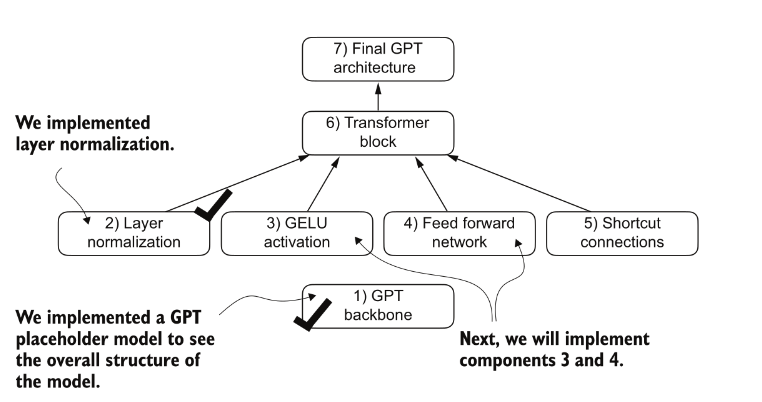

Unlike batch normalization, which normalizes across the batch dimension, layer nor-
malization normalizes across the feature dimension. Layer normalization offers more flexibility and stability which is beneficial for training and inference

### GELU Activation
Historically, the ReLU activation function has been commonly used in deep learning
due to its simplicity and effectiveness across various neural network architectures.
However, in LLMs, several other activation functions are employed beyond the tradi-
tional ReLU. Two notable examples are GELU (Gaussian error linear unit) and SwiGLU
(Swish-gated linear unit). GELU and SwiGLU are more complex and smooth activation functions incorpo-
rating Gaussian and sigmoid-gated linear units, respectively. They offer improved per-
formance for deep learning models, unlike the simpler ReLU.

In [11]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return 0.5 * x * (1+torch.tanh(
            torch.sqrt(torch.tensor(2.0/torch.pi)) *
            (x + 0.044715 * torch.pow(x,3))
        ))

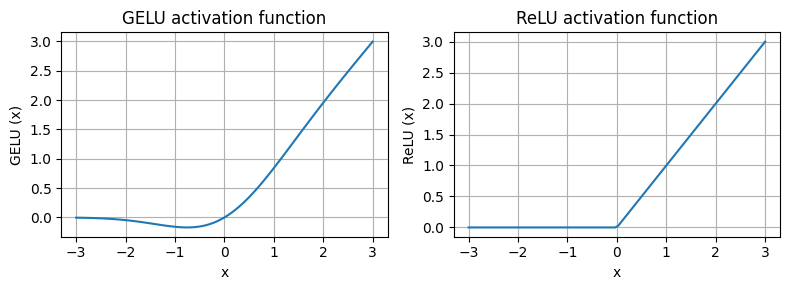

In [12]:
# to compare ReLU and GELU side by side:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3,3,100) # this creates 100 sample data points in the range -3 to 3
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8,3))

for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1,2,i)
    plt.plot(x,y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label} (x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

The smoothness of GELU can lead to better optimization properties during training,
as it allows for more nuanced adjustments to the model’s parameters. In contrast,
ReLU has a sharp corner at zero which can sometimes make opti-
mization harder, especially in networks that are very deep or have complex architec-
tures. Moreover, unlike ReLU, which outputs zero for any negative input, GELU
allows for a small, non-zero output for negative values. This characteristic means that
during the training process, neurons that receive negative input can still contribute to
the learning process, albeit to a lesser extent than positive inputs.



In [13]:
# using the GELU function to implement the small NN module, FeedForward 

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            nn.GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)
        

The FeedForward module plays a crucial role in enhancing the model’s ability to learn
from and generalize the data. Although the input and output dimensions of this
module are the same, it internally expands the embedding dimension into a higher dimensional space through the first linear layer. This expan-
sion is followed by a nonlinear GELU activation and then a contraction back to the original dimension with the second linear transformation. Such a design allows for the
exploration of a richer representation space.

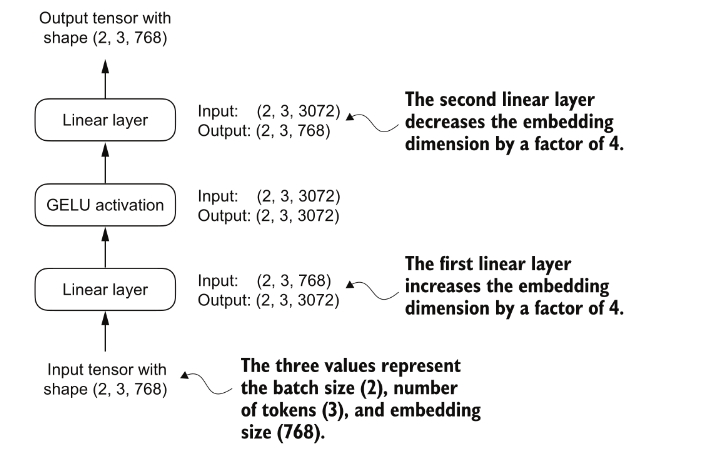

In [14]:
feed_forward_network = FeedForward(GPT_CONFIG_124M)
x = torch.randn(2,3,768)
y = feed_forward_network(x)
print(y.shape)

torch.Size([2, 3, 768])


#### Adding shortcut connections
shortcut connections AKA skip or residual connections were originally proposed for deep networks in computer vision to mitigate the challenge of vanishing gradients. This challenge occurs when gradients (which guide weight updates during training) become smaller during backpropagation, making it difficult for the network to learn effectively. Shortcut connections create an alternative, shorter path for the gradient to flow through the network by skipping one or more layers which is achieved by adding the output of the previous layer to the output of the current layer. This allows the network to learn more effectively and avoid vanishing gradients.

In [15]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), nn.GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), nn.GELU()),
        ])
    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x
        

In [16]:
# we will use the above to initialize a neural network without shortcut connections

layer_sizes = [3,3,3,3,3,1]

sample_input = torch.tensor([1., 0., -1.])
torch.manual_seed(123)

model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)

In [17]:
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([0.])

    loss = nn.MSELoss()
    loss = loss(output, target)
    
    loss.backward()
    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name }: has gradient mean of {param.grad.abs().mean().item()}")
    

In [18]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight: has gradient mean of 0.00020174118981231004
layers.1.0.weight: has gradient mean of 0.00012011769285891205
layers.2.0.weight: has gradient mean of 0.0007152436301112175
layers.3.0.weight: has gradient mean of 0.00139885104727
layers.4.0.weight: has gradient mean of 0.005049602594226599


In [19]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight: has gradient mean of 0.22186800837516785
layers.1.0.weight: has gradient mean of 0.20709273219108582
layers.2.0.weight: has gradient mean of 0.3292388319969177
layers.3.0.weight: has gradient mean of 0.2667772173881531
layers.4.0.weight: has gradient mean of 1.3268063068389893


In conclusion, shortcut connections are important for overcoming the limitations
posed by the vanishing gradient problem in deep neural networks. Shortcut connections are a core building block of very large models such as LLMs, and they will help
facilitate more effective training by ensuring consistent gradient flow across layers

#### implementing the transformer block
the transformer block, which is repeated a dozen times in the 124-million-parameter GPT-2 architecture, combines several concepts we have previously covered:
multi-head attention, layer normalization, dropout, feed forward layers, and GELU
activations. Later, we will connect this transformer block to the remaining parts of the
GPT architecture.

When a transformer block pro-
cesses an input sequence, each element in the sequence (for example, a word or sub-word token) is represented by a fixed-size vector (in this case, 768 dimensions). The
operations within the transformer block, including multi-head attention and feed forward layers, are designed to transform these vectors in a way that preserves their
dimensionality.

In [20]:
from attention_mechanism import MultiHeadAttention

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attention = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.feedforward = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
        
    def forward(self, x):
        
        shortcut = x
        x = self.norm1(x)
        x = self.attention(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        
        shortcut = x
        x = self.norm2(x)
        x = self.feedforward(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x

2.9.1+cu128
tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])
Attention weights:  tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum:  tensor(1.0000)


In [21]:
torch.manual_seed(123)
x = torch.randn(2, 4, 768)
transformer_block = TransformerBlock(GPT_CONFIG_124M)
output = transformer_block(x)

print("Input shape:", x.shape)
print("outputput shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
outputput shape: torch.Size([2, 4, 768])


As we can see, the transformer block maintains the input dimensions in its output, indicating that the transformer architecture processes sequences of data without altering
their shape throughout the network.
The preservation of shape throughout the transformer block architecture is not
incidental but a crucial aspect of its design. This design enables its effective application across a wide range of sequence-to-sequence tasks, where each output vector
directly corresponds to an input vector, maintaining a one-to-one relationship. However, the output is a context vector that encapsulates information from the entire
input sequence. This means that while the physical dimensions of the
sequence (length and feature size) remain unchanged as it passes through the transformer block, the content of each output vector is re-encoded to integrate contextual
information from across the entire input sequence.

GPT model implementation

In [22]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        
        tok_embeds = self.tok_emb(in_idx)
        
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [23]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)

output = model(batch)
print("Input batch:", batch)
print("\nOutput shape", output.shape)
print(output)

Input batch: tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape torch.Size([2, 4, 50257])
tensor([[[ 0.3612,  0.4223, -0.0712,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1793, -0.5660, -0.9486,  ...,  0.0477,  0.5181, -0.3169],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1017, -0.4326, -0.2553],
         [-1.0076,  0.3419, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2565,  0.0901,  0.0335,  ...,  0.2658,  0.4454, -0.6806],
         [ 0.1229,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2245],
         [ 1.0558,  1.0318, -0.2799,  ...,  0.6935,  0.3205, -0.3178],
         [-0.1567,  0.3928,  0.3288,  ...,  1.2630, -0.1859,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


In [24]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the GPT model: {total_params}")

Total number of parameters in the GPT model: 163009536


there is a discrepancy in the number of parameters. we expect 124-million in a typical GPT-2 model. the reason for this is called weight tying . the original GPT-2 architecture reuses the weights from the token embedding layer in its output layer.

In [25]:
print("Token embedding weights shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding weights shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [26]:
total_params_gpt2 = (
    total_params - sum(p.numel() for p in model.out_head.parameters())
)

print(f"Number of trainable parameters "
      f"in the GPT-2 model with weight tying: {total_params_gpt2}")

Number of trainable parameters in the GPT-2 model with weight tying: 124412160


In [27]:
total_size_bytes = total_params * 4  # assuming 32-bit (4 bytes) floats
total_size_mb = total_size_bytes / (1024 ** 2)
print(f"Total size of the GPT model parameters: {total_size_mb:.2f} MB")

Total size of the GPT model parameters: 621.83 MB


#### Next-token generation of text
The next-token generation process illustrates a single step
where the GPT model generates the next token given its input. In each step, the model
outputs a matrix with vectors representing potential next tokens. The vector corresponding to the next token is extracted and converted into a probability distribution via
the softmax function. Within the vector containing the resulting probability scores, the
index of the highest value is located, which translates to the token ID. This token ID is
then decoded back into text, producing the next token in the sequence. Finally, this
token is appended to the previous inputs, forming a new input sequence for the subsequent iteration. This step-by-step process enables the model to generate text sequentially, building coherent phrases and sentences from the initial input context.
In practice, we repeat this process over many iterations.
until we reach a user-specified number of generated tokens. In code, we can implement the token-generation process as shown in the following listing.

In [28]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:] # idx is (batch_size, n_tokens) array of indices in the current context
        with torch.no_grad():
            logits = model(idx_cond)
            
        logits = logits[:, -1, :]  # focus on the last time step so that (batch_size, n_token, vocab_size) becomes (batch_size, vocab_size)
        probs = torch.softmax(logits, dim=-1) # probs has shape (batch_size, vocab_size)
        idx_next = torch.argmax(probs, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [29]:
start_context = "In a distant future, humanity has"
encoded = tokenizer.encode(start_context)
print("Encoded input:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # shape (1, n_tokens)
print("Encoded tensor shape:", encoded_tensor.shape)

Encoded input: [818, 257, 12899, 2003, 11, 9265, 468]
Encoded tensor shape: torch.Size([1, 7])


In [30]:
model.eval()
output = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output", output)
print("Output length:", len(output[0]))

Output tensor([[  818,   257, 12899,  2003,    11,  9265,   468, 38346, 17060, 48727,
         27520,  7603,   980]])
Output length: 13


In [31]:
decoded_text = tokenizer.decode(output.squeeze(0).tolist())
print("Decoded generated text:\n", decoded_text)

Decoded generated text:
 In a distant future, humanity hasabytesPutiniteratorRank indicate differe


As we can see, the model generated gibberish, which is not at all like the coherent text we would have expected. What happened? The reason the model is unable to
produce coherent text is that we haven’t trained it yet. So far, we have only implemented
the GPT architecture and initialized a GPT model instance with initial random weights.